<a href="https://colab.research.google.com/github/Oyinmiebi/Oyinmiebi/blob/main/long_document_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Long Document Understanding with Qwen3-VL

In this notebook, we delve into the capabilities of the Qwen3-VL model for understanding **long document with hundreds of pages**. Our objective is to showcase how this advanced model can be applied to long/full-PDF document analysis scenarios.


#### \[Setup\]

We start by loading the pre-trained model.


In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen_vl_utils -U

In [ ]:
import torch
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

model_path = "Qwen/Qwen3-VL-4B-Instruct"

model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)



Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Load PDF pages as images

In [ ]:
!sudo apt update
!sudo apt install poppler-utils -y
!pip install pdf2image

In [ ]:
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
from pdf2image import convert_from_path


def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"File downloaded to {dest_path}")


def get_pdf_images(pdf_path, dpi=144, cache_dir='cache'):
    os.makedirs(cache_dir, exist_ok=True)

    # Create a hash for the PDF path to use in cache filenames
    pdf_hash = hashlib.md5(pdf_path.encode('utf-8')).hexdigest()

    # Handle URL
    if pdf_path.startswith('http://') or pdf_path.startswith('https://'):
        pdf_file_path = os.path.join(cache_dir, f'{pdf_hash}.pdf')
        if not os.path.exists(pdf_file_path):
            download_file(pdf_path, pdf_file_path)
        else:
            print(f"Load cached PDF file from {pdf_file_path}.")
    else:
        pdf_file_path = pdf_path

    # Check for cached images
    images_cache_file = os.path.join(cache_dir, f'{pdf_hash}_{dpi}_images.npy')
    if os.path.exists(images_cache_file):
        images = np.load(images_cache_file, allow_pickle=True)
        pil_images = [Image.fromarray(image) for image in images]
        print(f"Load {len(images)} pages from cache: {images_cache_file}.")
        return pdf_file_path, pil_images

    # Convert PDF to images if not cached
    print(f"Converting PDF to images at {dpi} DPI...")
    pil_images = convert_from_path(pdf_file_path, dpi=dpi)

    # image file size control
    resize_pil_images = []
    for img in pil_images:
        width, height = img.size
        max_side = max(width, height)
        max_side_value = 1500
        if max_side > max_side_value:
            img = img.resize((width * max_side_value // max_side, height * max_side_value // max_side))
        resize_pil_images.append(img)
    pil_images = resize_pil_images

    images = [np.array(img) for img in pil_images]

    # Save to cache
    np.save(images_cache_file, images)
    print(f"Converted and cached {len(images)} pages to {images_cache_file}.")

    return pdf_file_path, pil_images


def create_image_grid(pil_images, num_columns=8):

    num_rows = math.ceil(len(pil_images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image

import base64
from io import BytesIO

def image_to_base64(img, format="PNG"):

    buffered = BytesIO()
    img.save(buffered, format=format)
    img_bytes = buffered.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    return img_base64


Inference function with HuggingFace.

In [ ]:
def inference(images, prompt, sys_prompt="", max_new_tokens=4096, min_pixels=512*32*32, max_pixels=730*32*32, return_input=False):

    print("Send {} pages to the model... \nWaiting for response...".format(len(images)))
    content_list = []
    for image in images:
        base64_image = image_to_base64(image)
        content_list.append(
            {
                "type": "image_url",
                # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                # PNG image:  f"data:image/png;base64,{base64_image}"
                # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                # WEBP image: f"data:image/webp;base64,{base64_image}"
                "image_url": {"url": f"data:image/png;base64,{base64_image}"},
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
            },
        )
    content_list.append({"type": "text", "text": prompt})
    messages=[
        # {
        #     "role": "system",
        #     "content": [{"type":"text","text": sys_prompt}]
        # },
        {
            "role": "user",
            "content": content_list
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("input text:", text)

    inputs = processor(text=[text], images=images, padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

Inference function with API using OpenAI SDK.

**Important Notice:**
- The API must support multi-image inputs. The format used here is compatible with DashScope's API.
- Ensure your API key has the necessary permissions and funds.
- For very long documents, be mindful of API limits on the number of total tokens or request size.

In [ ]:
from openai import OpenAI

def inference_with_api(images, prompt, sys_prompt="", model_id="qwen-vl-max-latest", min_pixels=590*32*32, max_pixels=730*32*32):
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx"."
        api_key=os.getenv('DASHSCOPE_API_KEY'),
        base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )
    print("Send {} pages to the model... \nWaiting for response...".format(len(images)))

    content_list = []
    for image in images:
        base64_image = image_to_base64(image)
        content_list.append(
            {
                "type": "image_url",
                # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                # PNG image:  f"data:image/png;base64,{base64_image}"
                # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                # WEBP image: f"data:image/webp;base64,{base64_image}"
                "image_url": {"url": f"data:image/png;base64,{base64_image}"},
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
            },
        )
    content_list.append({"type": "text", "text": prompt})
    messages = [
        # {
        #     "role": "system",
        #     "content": [{"type":"text","text": sys_prompt}]
        # },
        {
            "role": "user",
            "content": content_list
        }
    ]

    completion = client.chat.completions.create(
        model=model_id,
        messages=messages,
        # top_p=0.8,
        # temperature=0.01,
        # presence_penalty=1.5,
        # max_tokens=16384,
        # extra_body={
        #     'top_k': 1,
        #     'repetition_penalty': 1.0,
        # },
    )
    return completion.choices[0].message.content

### Example: Analyzing an Academic PDF

In this section, we demonstrate how the model can be used to read and understand a long PDF document. We will use an academic file and ask the model to analyze it.

#### 1. Use a local HuggingFace model to inference.

In [ ]:

# Using a PDF document URL or local path.
longdoc_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-VL/demo/longdoc/documents/Qwen2.5-VL.pdf"
prompt = "Please summarize the key contributions of this paper based on its abstract and introduction."

# This will download the PDF, convert its pages to images, and then run inference.
pdf_path, images = get_pdf_images(longdoc_url, dpi=144)

# # You can use this to visualize documents in thumbnail format.
# image_grid = create_image_grid(images, num_columns=8)
# display(image_grid.resize((1000, 1000)))

response = inference(images, prompt)
display(Markdown(response))

Load cached PDF file from cache/ebfa3d4fe317e602bcad4c5dc5814908.pdf.
Load 23 pages from cache: cache/ebfa3d4fe317e602bcad4c5dc5814908_144_images.npy.
Send 23 pages to the model... 
Waiting for response...


The abstract on page 1 (image 0) introduces Qwen2.5-VL as a flagship model with significant advancements in foundational capabilities and innovative functionalities. It highlights features like precise object localization, robust document parsing, long-video comprehension, dynamic resolution processing, and absolute time encoding. The introduction on page 2 (image 1) elaborates that the paper's goal is to create an agent amplifier for real-world applications by leveraging the latest Qwen2.5 LLM. It outlines four technical contributions: implementing window attention in the visual encoder, introducing dynamic FPS sampling, upgrading MRoPE in the temporal domain, and curating high-quality data. These points collectively represent the core contributions of the paper.

#### 2. Use API for inference.

Load cached PDF file from cache/bd1869acdae64bed0a41c4648c3f9446.pdf.
Load 35 pages from cache: cache/bd1869acdae64bed0a41c4648c3f9446_144_images.npy.


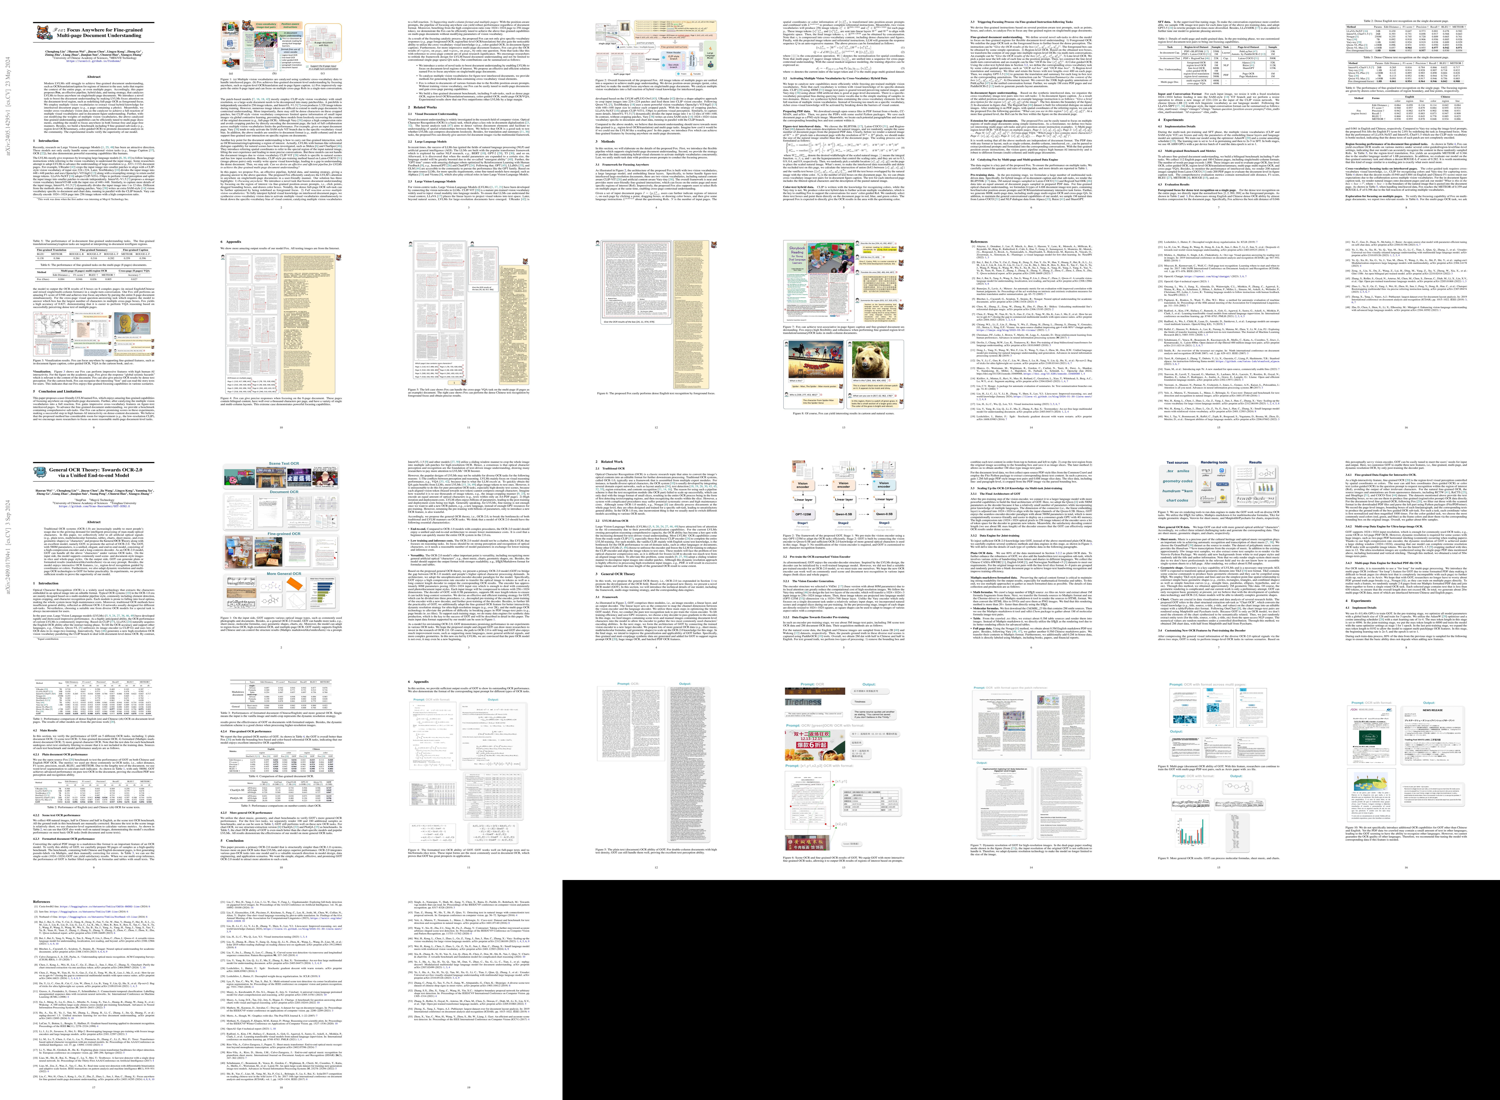

(1158, 1500)
Send 35 pages to the model... 
Waiting for response...


To determine the total number of tables in the provided document, a systematic count across all pages is required.

The first paper, "Fox: Focus Anywhere for Fine-grained Multi-page Document Understanding," contains the following tables:
- Table 1 on page 7 (image 6)
- Table 2 on page 8 (image 7)
- Table 3 on page 8 (image 7)
- Table 4 on page 8 (image 7)
- Table 5 on page 9 (image 8)
- Table 6 on page 9 (image 8)

This accounts for 6 tables in the first paper.

The second paper, "General OCR Theory: Towards OCR-2.0 via a Unified End-to-end Model," contains the following tables:
- Table 1 on page 9 (image 24)
- Table 2 on page 9 (image 24)
- Table 3 on page 10 (image 25)
- Table 4 on page 10 (image 25)
- Table 5 on page 10 (image 25)

This accounts for 5 tables in the second paper.

Summing the tables from both papers: 6 + 5 = 11.

Therefore, there are 11 tables in total across the entire document.

In [ ]:
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
# Using a PDF document URL or local path.
longdoc_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-VL/demo/longdoc/documents/fox_got_merge_code.pdf"
prompt = "How many tables?"

# This will download the PDF, convert its pages to images, and then run inference with API.
pdf_path, images = get_pdf_images(longdoc_url, dpi=144)

# You can use this to visualize documents in thumbnail format.
image_grid = create_image_grid(images, num_columns=8)
display(image_grid.resize((1500, 1100)))
print(images[0].size)

response = inference_with_api(images, prompt)
display(Markdown(response))